In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc, accuracy_score, roc_curve, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
plt.style.use('ggplot')

In [2]:
# List of all the lineages we will be making dataframes for - some of the DFs don't have a col named depmapid but have depmapids, will require some cleaning
lineages = ["kidney", "breast", "blood", "liver", "urinary_tract", "colorectal", "ovary", "pancreas"]
lineage_df_dict = {}

In [3]:
# List of all the feature dataframes we are going to read into the lineage dataframes
features = ["effect", "dependency", "expression", "gene_cn"]
feature_df_dict = {}

In [6]:
sample_info_df = pd.read_csv('data/sample_info.csv')

In [7]:
sample_info_df

,DepMap_ID,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
0,ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_V607,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-JnARLB,NaN,Clear cell renal cell carcinoma,C4033,NaN
1,ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Female,DSMZ,CVCL_0089,NaN,...,b_cell,NaN,NaN,NaN,NaN,PT-p2KOyI,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
2,ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN,Female,Academic lab,CVCL_1497,NaN,...,NSCLC_adenocarcinoma,NaN,NaN,NaN,NaN,PT-9p1WQv,NaN,Lung adenocarcinoma,C3512,NaN
3,ACH-000043,Hs 895.T,HS895T,HS895T_FIBROBLAST,NaN,NaN,Female,ATCC,CVCL_0993,NaN,...,NaN,NaN,2D: adherent,NaN,NaN,PT-rTUVZQ,NaN,Melanoma,C3224,NaN
4,ACH-000049,HEK TE,HEKTE,HEKTE_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_WS59,NaN,...,NaN,NaN,NaN,immortalized,NaN,PT-qWYYgr,NaN,NaN,NaN,No information is available about this cell li...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,ACH-002393,CRO-AP3,CROAP3,CROAP3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,Sanger,CVCL_1810,NaN,...,b_cell_primary_effusion,NaN,NaN,NaN,NaN,PT-TC0lZM,NaN,Primary effusion lymphoma,C6915,NaN
1836,ACH-002394,GEO,GEO,GEO_LARGE_INTESTINE,NaN,NaN,NaN,Sanger,CVCL_0271,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-Fa1q9q,NaN,Colon carcinoma,C4910,NaN
1837,ACH-002395,HuH-6 Clone 5,HUH6CLONE5,HUH6CLONE5_LIVER,NaN,NaN,Male,Sanger,CVCL_1296,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-TtIXsL,ACH-000671,Hepatoblastoma,C3728,NaN
1838,ACH-002396,Sarc9371,SARC9371,SARC9371_BONE,NaN,NaN,NaN,Sanger,CVCL_5G89,NaN,...,NaN,NaN,NaN,NaN,NaN,PT-715FdC,NaN,Osteosarcoma,C9145,NaN


In [9]:
folder_path = "data/"

for file_name in os.listdir(folder_path):
    for feature in features:
        if file_name.endswith('.csv') and feature in file_name:
            file_path = os.path.join(folder_path, file_name)
            feature_df_dict[feature] = pd.read_csv(file_path)
            feature_df_dict[feature].columns = [column.split(' ')[0] for column in feature_df_dict[feature].columns]
            feature_df_dict[feature].rename(columns={feature_df_dict[feature].columns[0]: "DepMap_ID"}, inplace=True)
            feature_df_dict[feature] = pd.merge(feature_df_dict[feature], sample_info_df[['DepMap_ID', 'lineage']], on='DepMap_ID', how='left')
            feature_df_dict[feature].drop("DepMap_ID", axis=1, inplace=True)
            feature_df_dict[feature] = feature_df_dict[feature].pivot_table(index='lineage', aggfunc='mean')

In [10]:
for feature in features:
    for lineage in lineages:
        temp_df = feature_df_dict[feature].loc[feature_df_dict[feature].index == lineage].transpose()
        temp_df.index.name = 'gene'
        if lineage in lineage_df_dict:
            temp_df.rename(columns={lineage : feature}, inplace=True)
            lineage_df_dict[lineage] = pd.merge(lineage_df_dict[lineage], temp_df, on="gene", how="outer").dropna()
        else:
            lineage_df_dict[lineage] = pd.DataFrame({feature: temp_df[lineage]}, index=temp_df.index)
            lineage_df_dict[lineage].index.name = 'gene'
            lineage_df_dict[lineage].reset_index(inplace=True)

In [11]:
lineage_df_dict['colorectal']

,gene,effect,dependency,expression,gene_cn
0,A1BG,-0.015041,0.043599,0.590738,1.002046
1,A1CF,-0.068805,0.083945,1.262503,1.031954
2,A2M,0.001877,0.035082,0.285868,1.075952
3,A2ML1,0.034582,0.030788,0.309722,1.075789
4,A3GALT2,-0.046617,0.062978,0.009425,0.912126
...,...,...,...,...,...
17280,ZYG11A,-0.020647,0.046334,0.178135,0.920793
17281,ZYG11B,-0.094004,0.087456,2.296709,0.920752
17282,ZYX,-0.015553,0.045229,6.060374,1.142463
17283,ZZEF1,-0.065964,0.070773,3.277261,0.914023


In [12]:
training_dfs = {}
training_lineages = {"kidney" : "kidney", 
                     "breast" : "breast", 
                     "leukemia" : "blood", 
                     "liver" : "liver", 
                     "bladder" : "urinary_tract",
                     "colon" : "colorectal", 
                     "ovarian" : "ovary", 
                     "pancreatic" : "pancreas"}
for k, v in training_lineages.items():
    df = pd.read_csv(f"training_sets_genes/{k}_training_genes_set.csv")
    df = df.merge(lineage_df_dict[v], on="gene", how='left').fillna(0)
    lineage_df_dict[v] = pd.merge(lineage_df_dict[v], df, indicator=True, how='left', on=list(lineage_df_dict[v].columns)).query('_merge == "left_only"').drop('_merge', axis=1)
    lineage_df_dict[v].drop(columns=['label'], inplace=True)
    df.set_index('gene', inplace=True)
    lineage_df_dict[v].set_index('gene', inplace=True)
    training_dfs[k] = df

In [13]:
rev_training_lineages = {value: key for key, value in training_lineages.items()}

## Principal Component Analysis (PCA)

In [33]:
from sklearn.decomposition import PCA

pca_vectors_input = {} 
pca_vectors_output = {}

# build inputs
for k, v in training_dfs.items():
    pca = PCA(n_components=2)
    input_vectors = training_dfs[k].drop(columns=['label']).values
    output_vectors = pca.fit_transform(input_vectors)
    pca_vectors_input[k] = input_vectors
    pca_vectors_output[k] = output_vectors

Text(0.5, 1.0, 'PCA Transform of Features Vectors by Lineage')

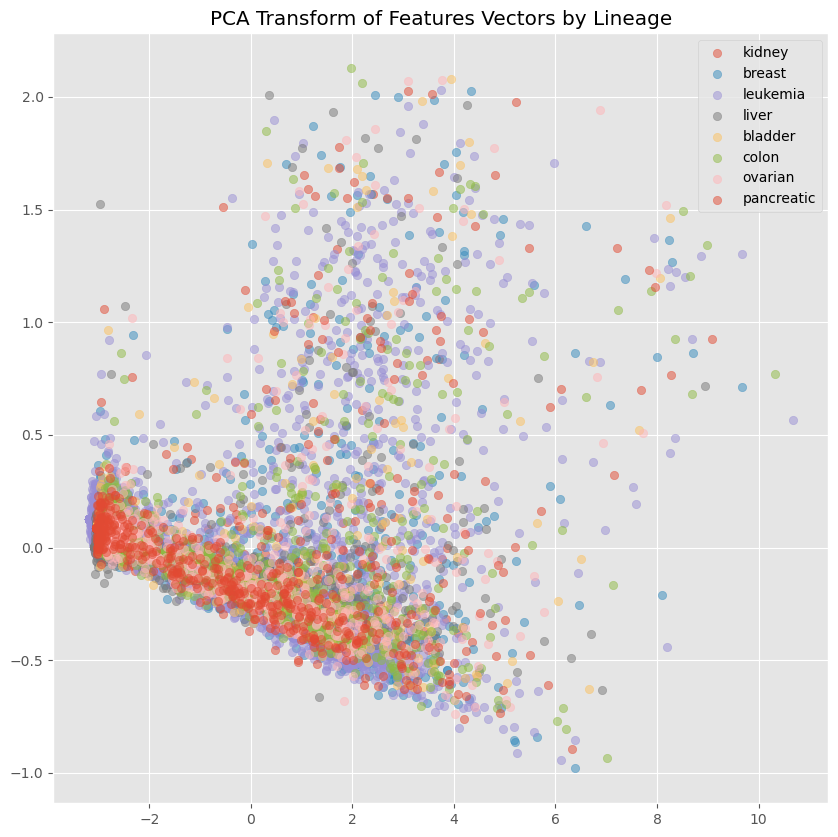

In [45]:

plt.figure(figsize=(10, 10))
for k, v in pca_vectors_output.items():
    plt.scatter(v[:, 0], v[:, 1], label=k, alpha=0.5)
plt.legend()
plt.title('PCA Transform of Features Vectors by Lineage')

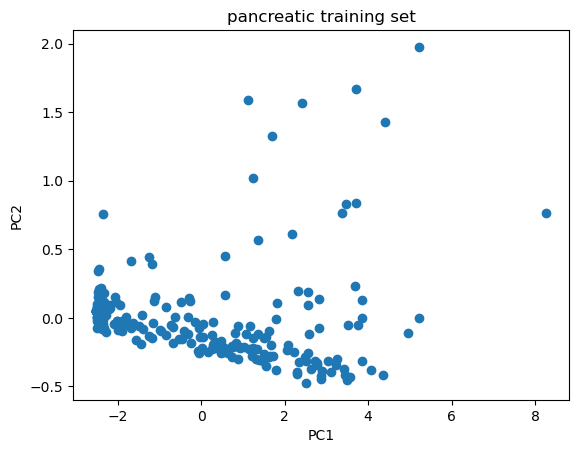

In [32]:
# plot pca 
plt.scatter(output_vectors[:, 0], output_vectors[:, 1])
plt.title(f"{k} training set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()